### RTML FINAL PRACTISE

Download the example LSTM code for learning a sine wave from .... <br>
Generate some data and train the model. It should take a few minues on your laptop in CPU mode. <br>
Place the code and show the resulting predicted future time sequence plot in the next cell.

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%pylab inline
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


#### Generate sine wave function

In [2]:
import numpy as np
import torch

np.random.seed(2)

def gen_sine(T,L,N):
    x = np.empty((N, L), 'int64')
    x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
    data = np.sin(x / 1.0 / T).astype('float64')
    return data

#### LSTM model

In [3]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for input_t in input.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.cat(outputs, dim=1)
        return outputs

#### Check device

In [4]:
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(device)

cpu


#### Generate data

In [60]:
T = 20
L = 1000
N = 100

data = gen_sine(T=T,L=L, N=N)

plt.plot(data[5])

input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])

test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])

#### Define model

In [61]:
seq = Sequence()
seq.double()

Sequence(
  (lstm1): LSTMCell(1, 51)
  (lstm2): LSTMCell(51, 51)
  (linear): Linear(in_features=51, out_features=1, bias=True)
)

#### Define Loss and Optimizer

In [62]:
criterion = nn.MSELoss()
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

#### Traning

In [63]:
EPOCH = 10

In [64]:
train_hist_loss = []
val_hist_loss = []
for i in range(EPOCH):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        #print('loss:', loss.item())
        train_hist_loss.append(loss)
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        future = 1000
        pred = seq(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        print('test loss:', loss.item())
        y = pred.detach().numpy()
        val_hist_loss.append(loss)
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    draw(y[0], 'r')
    draw(y[1], 'g')
    draw(y[2], 'b')
    plt.savefig('RTML_final/pdf/predict%d.pdf'%i)
    plt.close()

STEP:  0
test loss: 0.000925011539249783
STEP:  1
test loss: 8.867306794599545e-05
STEP:  2
test loss: 4.7006008204280805e-05
STEP:  3
test loss: 2.895191123707521e-05
STEP:  4
test loss: 2.2327365063459512e-05
STEP:  5
test loss: 1.0415929688237078e-05
STEP:  6
test loss: 9.520781440136864e-06
STEP:  7
test loss: 7.752430015762462e-06
STEP:  8
test loss: 7.370713827016343e-06
STEP:  9
test loss: 6.834692403963316e-06


### Results

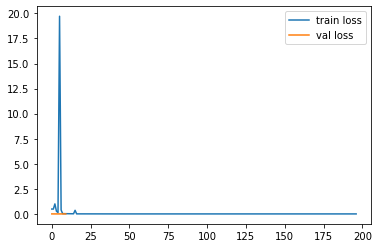

In [69]:
train_losses = []
test_losses = []

for loss in train_hist_loss:
    train_losses.append(loss.detach().numpy())

for loss in val_hist_loss:
    test_losses.append(loss.detach().numpy())
    
plt.plot(np.arange(0,197), np.array(train_losses).reshape(197,-1), label = "train loss")
plt.plot(np.arange(0,10), np.array(test_losses).reshape(10,-1), label = "val loss")
plt.legend()
plt.show()   

Next, modify the data generation code to add Gaussian noise with std = 1.0 and std = 2.0, retrain the model (you should train two models on data with the two different values of std), and show the results below including test loss information. Do you see any evidence of overfitting or are the results as expected?

#### Generate sing wave with noise

In [137]:
def gen_noise(mu,sigma,L):
    noise = np.random.normal(mu,sigma,L)
    return noise

def gen_sine_noise(T,L,N, mu, sigma):
    x = np.empty((N, L), 'int64')
    x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
#     data = x = np.empty((N, L))
    noise = np.empty((N,L))
    for i in range(N): 
        noise_single = gen_noise(mu,sigma, L) #.reshape(1,L)
        noise[i,:] = noise_single
#     print(noise)
    data = (np.sin(x / 1.0 / T).astype('float64')) + noise
#     data = torch.from_numpy(data)
#     torch.save(data, open('traindata.pt', 'wb'))
    return data

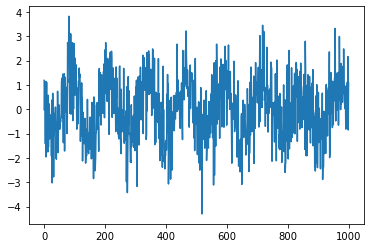

In [138]:
T = 20
L = 1000
N = 100
mu = 0
sigma = 1
data = gen_sine_noise(T=T,L=L, N=N, mu=mu, sigma=sigma)

plt.plot(data[1])

input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])

test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])

In [5]:
seq = Sequence()
seq.double()

criterion = nn.MSELoss()
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

EPOCH = 10
def train(input, target, test_input, test_target, EPOCH, which_noise):
    train_hist_loss = []
    val_hist_loss = []
    for i in range(EPOCH):
        print('STEP: ', i)
        def closure():
            optimizer.zero_grad()
            out = seq(input)
            loss = criterion(out, target)
            #print('loss:', loss.item())
            train_hist_loss.append(loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)
        # begin to predict, no need to track gradient here
        with torch.no_grad():
            future = 1000
            pred = seq(test_input, future=future)
            loss = criterion(pred[:, :-future], test_target)
            print('test loss:', loss.item())
            val_hist_loss.append(loss.item())
            y = pred.detach().numpy()
        # draw the result
        plt.figure(figsize=(30,10))
        plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
        plt.xlabel('x', fontsize=20)
        plt.ylabel('y', fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        def draw(yi, color):
            plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
            plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
        draw(y[0], 'r')
        draw(y[1], 'g')
        draw(y[2], 'b')
        plt.savefig('RTML_final/pdf/predict_{which_noise}{i}_{sigma}sigma.pdf'.format(which_noise=which_noise,i=i,sigma=sigma))
        plt.close()
    return train_hist_loss, val_hist_loss

In [140]:
train_hist_loss, val_hist_loss = train(input, target, test_input, test_target, EPOCH,"gen_sine_noise")

STEP:  0
test loss: 1.1126622993830828
STEP:  1
test loss: 1.1083039752836963
STEP:  2
test loss: 1.0755356202615838
STEP:  3
test loss: 1.1717016874368698
STEP:  4
test loss: 610.6773401461533
STEP:  5
test loss: 1.4246616840120978e+26
STEP:  6
test loss: 1.4387121111629196e+25
STEP:  7
test loss: 1.7565847907613215e+25
STEP:  8
test loss: 4.5145511494183534e+23
STEP:  9
test loss: 2.3227061351936184e+25


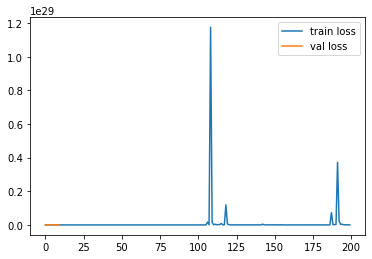

In [142]:
train_losses = []
test_losses = []

for loss in train_hist_loss:
    train_losses.append(loss) #.detach().numpy())

for loss in val_hist_loss:
    test_losses.append(loss) #.detach().numpy())
    
plt.plot(np.arange(0,200), np.array(train_losses).reshape(200,-1), label = "train loss")
plt.plot(np.arange(0,10), np.array(test_losses).reshape(10,-1), label = "val loss")
plt.legend()
plt.show()  

# %pylab inline
# img = mpimg.imread('predict_noise9_0.1.pdf')
# plt.figure(figsize = (10,10))
# imgplot = plt.imshow(img)
# plt.show()

In [143]:
T = 20
L = 1000
N = 100
mu = 0
sigma = 2
data = gen_sine_noise(T=T,L=L, N=N, mu=mu, sigma=sigma)

input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])

test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])

seq = Sequence()
seq.double()

criterion = nn.MSELoss()
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

EPOCH = 10

train_hist_loss, val_hist_loss = train(input, target, test_input, test_target, EPOCH, "gen_sine_noise")

STEP:  0
test loss: 4.194952451168443
STEP:  1
test loss: 4.184345307114765
STEP:  2
test loss: 1.7862978998159844e+23
STEP:  3
test loss: 3.239225643882247e+21
STEP:  4
test loss: 3.3058449998777407e+21
STEP:  5


KeyboardInterrupt: 

In [ ]:
plt.plot(len(train_hist_loss), train_hist_loss, label = "train loss")
plt.plot(len(val_hist_loss), val_hist_loss, label = "val loss")

%pylab inline
img = mpimg.imread('predict_noise9_0.2.pdf')
plt.figure(figsize = (10,10))
imgplot = plt.imshow(img)
plt.show()

Next using sigma = 2.0, modify the data generation code to gradually increase the wave length (decrease the frequency of the sine wave over time) <br>
Start with T = 20 as in the sample code but linearly increase it to 40 for sample 1000 and T = 80 for sample 2000

In [10]:
def gen_sine_noise_grad(T, T_start, T_end, L,N, mu, sigma):
    noise = np.random.normal(mu,sigma,L)
#     m = (T_end - T_start) /L
    x = np.empty((N, L), 'int64')
    x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
    data = np.ones((N, L))
    T_grad = np.linspace(T_start,T_end,L)  
    for i in range(N):
        holder = np.sin(x[i,:] / 1.0 / T_grad).astype('float64')
        for j in range(len(holder)):
            data[i,j] = holder[j]
    data = data + noise
    return data

STEP:  0
test loss: 3.8378952098054797
STEP:  1
test loss: 3.8149742321740496
STEP:  2
test loss: 3.7908150320434664
STEP:  3
test loss: 3.756235370421437
STEP:  4
test loss: 3.688579884852615
STEP:  5
test loss: 3.6389479861128065
STEP:  6
test loss: 3.503485184038509
STEP:  7
test loss: 3.3383488932179026
STEP:  8
test loss: 3.1671616403755607
STEP:  9
test loss: 2.9650603444388373


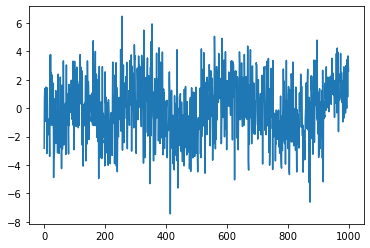

In [8]:
T = 20
T_start = 20
T_end = 40
L = 1000
N = 100
mu = 0
sigma = 2
data = gen_sine_noise_grad(T = T, T_start=T_start,T_end=T_end,L=L, N=N, mu=mu, sigma=sigma)

data_0 = data[50]
# print(data_0)
plt.plot(data_0)
input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])

test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])

seq = Sequence()
seq.double()

criterion = nn.MSELoss()
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

EPOCH = 10

train_hist_loss, val_hist_loss = train(input, target, test_input, test_target, EPOCH, "gen_sine_noise_grad")

In [11]:
T = 20
T_start = 20
T_end = 80
L = 2000
N = 100
mu = 0
sigma = 2
data = gen_sine_noise_grad(T = T, T_start=T_start,T_end=T_end,L=L, N=N, mu=mu, sigma=sigma)

input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])

test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])

seq = Sequence()
seq.double()

criterion = nn.MSELoss()
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

EPOCH = 10

which_noise = "gen_sine_noise_grad_80"

train_hist_loss, val_hist_loss = train(input, target, test_input, test_target, EPOCH, which_noise)

STEP:  0
test loss: 4.092442614897031
STEP:  1
test loss: 4.0795317031794385
STEP:  2
test loss: 4.063868323958329
STEP:  3
test loss: 4.056821304966727
STEP:  4
test loss: 4.031835537026045
STEP:  5
test loss: 4.019608293351667
STEP:  6
test loss: 4.000915440261653
STEP:  7
test loss: 3.9891180070648558
STEP:  8
test loss: 6.251307897317946e+30
STEP:  9
test loss: 4.038181539315795e+30


Make a simple change to the structure of the model to imporove its performance, Discuss what oyu did and the results you observe below and place you rcode and the resulting plot in the cell below

### Question 2

By now you have an excellent DQN model able to play tic-tac-toe. Load your trained model and give the "O" play's value q(s,a) for the following state-action pair:



In [1]:
import math, random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

import matplotlib.pyplot as plt

import gym
import numpy as np

from collections import deque
from tqdm import trange

import importlib
from collections import defaultdict
import torch
import numpy

# Select GPU or CPU as device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        # Add batch index dimension to state representations
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [3]:
class DQN(nn.Module):
    
    def __init__(self, n_state, n_action):
        super(DQN, self).__init__()        
        self.layers = nn.Sequential(
            nn.Linear(n_state, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, n_action)
        )
        
    def forward(self, x):
        
        return self.layers(x)
    
    def act(self, state, epsilon):
        # Get an epsilon greedy action for given state
        if random.random() > epsilon: # Use argmax_a Q(s,a)
            state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
            q_value = self.forward(state)
            q_value = q_value.cpu()
            action = q_value.max(1)[1].item()            
        else: # get random action
            action = random.randrange(n_action)
        return action
    def get_q_value(self, state):
        state = autograd.Variable(torch.Tensor(state).unsqueeze(0)).to(device)
#             print(state.shape)
        q_value = self.forward(state)
        q_value = q_value.cpu()
#             print(q_value.shape)
        action = q_value.max(1)[1].item() 
        
        return q_value, action

In [4]:
def train(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99):
    losses = []
    all_rewards = []
    episode_reward = 0
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)

    # Get initial state input
    state = env.reset()
    state = state.reshape(27)
    
    # Execute episodes iterations
    for episode in tr:
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,tot_reward/(episode+1)))
        tr.refresh() 

        # Get initial epsilon greedy action
        epsilon = eps_by_episode(episode)
        state = state.reshape(27)
        action = model.act(state, epsilon)
        
        # Take a step
        next_state, reward, done = env.step(action)
        next_state = next_state.reshape(27)
        
        # Append experience to replay buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        episode_reward += reward
        
        state = next_state

        # Start a new episode if done signal is received
        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        # Train on a batch if we've got enough experience
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(model, batch_size, gamma)
            losses.append(loss.item())
            
    plot(episode, all_rewards, losses)  
    return model,all_rewards, losses


In [5]:
def plot(episode, rewards, losses):
    # clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)   
    plt.show()

In [6]:
game_name = 'tictactoe'
game_module = importlib.import_module("Lab13.games." + game_name)
env = game_module.Game()

env.reset()

n_state = 27

n_action = 9

model = DQN(n_state = n_state, n_action = n_action).to(device)

replay_buffer = ReplayBuffer(1000)

In [7]:
model.load_state_dict(torch.load(f'Lab14/tictactoe-fcdqn-1M.pth'))

<All keys matched successfully>

In [14]:
state = env.reset()
state = state.reshape(27)

# create the first state
state, reward, done = env.step(0)
env.render()

state = state.reshape(27)

q_value, action = model.get_q_value(state)
print(action)
print(q_value.shape)
print(q_value[0][4])
print(q_value[0][6])
print(q_value[0][action])

 O |   |   
---+---+---
   |   |   
---+---+---
   |   |   
tensor([[-0.3860, -0.9390, -0.6156, -0.2993, -0.7885, -0.8351, -0.6237, -1.7498,
         -0.0379]], grad_fn=<AddmmBackward>)
8
torch.Size([1, 9])
tensor(-0.7885, grad_fn=<SelectBackward>)
tensor(-0.6237, grad_fn=<SelectBackward>)
tensor(-0.0379, grad_fn=<SelectBackward>)


In [32]:
state = env.reset()
state = hash(tuple(state.reshape(-1)))


def gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay):
    eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)
    return eps_by_episode

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500
eps_by_episode = gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay)

player = 1
is_done = False
while not is_done:
    if env.to_play() == player:
        available_action = env.legal_actions()
        print("available action:",available_action)
#         action = epsilon_greedy_policy(state, optimal_Q, available_action)
#         action = 0
        next_state, reward, is_done = env.step(action)
        next_state = hash(tuple(next_state.reshape(-1)))
        print("RL agent")
        print(env.action_to_string(action))
    else:
        action = env.expert_agent()
        next_state, reward, is_done = env.step(action)
        next_state = hash(tuple(next_state.reshape(-1)))
        print("Expert agent")
        print(env.action_to_string(action))

    state = next_state
    env.render()

available action: [0, 1, 2, 3, 4, 5, 6, 7, 8]
RL agent
Play row 1, column 3
   |   | O 
---+---+---
   |   |   
---+---+---
   |   |   
Expert agent
Play row 2, column 1
   |   | O 
---+---+---
 X |   |   
---+---+---
   |   |   
available action: [0, 1, 4, 5, 6, 7, 8]
RL agent
Play row 2, column 1
   |   | O 
---+---+---
 X |   |   
---+---+---
   |   |   
